Fit of the grow rate $f$ from redshfit space distorsion of the xi of BOSS' catalogues computed with Euclid's code 

The model that I am going to fit is the following:

1) $P_g(k,\mu) = exp(-(fk\mu\sigma_v)^2)(b_1 + f\mu^2)P_{dw}$ (1) 

where $P_{dw}$ is the power spectrum de-wiggled, and the free parameters to fitting are $f$, $b_1$ and $\sigma_v$

2)The euclid code returns the multipoles of the power spectrum, so I decompose the anistropic power spectrum showed in (1) in multipoles:

$P_\ell(k) = \frac{(2*\ell + 1)}{2}\int_{-1}^{1} d\mu P(k,\mu) \mathscr{L}_\ell(\mu)$

3) I use the hankle function to obtain the xi from the pk

4) I am going to fit $\xi_\ell$ with the covariance matrix that Claudio computed in set_covariance code

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import camb
import scipy
from scipy.special import legendre
import hankl
import iminuit

First of all I create the model of the power spectrum 

I will use the $P_{dw}$ computed by Claudio.
$P_{dw}$ is the power spectrum with damped BAO wiggles:

$P_{dw} = P_{nw} + (1 + k^2\Sigma^2)e^{(-k^2\Sigma^2)}(P - P_{nw})$

In [2]:
pk_dw=np.load('pk_dewiggled.npy')
kh = np.load('kh.npy')

In [3]:
PK_dw = scipy.interpolate.interp1d(kh, pk_dw, kind='cubic', fill_value='extrapolate')

In [4]:
b1 = 2.0
f = 0.71
sigma_v= 3.0
p_k_mu = lambda k, mu: (b1 + f*mu**2)**2*PK_dw(k)*np.exp(-f*k**2*mu**2*sigma_v**2)

In [5]:
deg = 51

mu, weights = np.polynomial.legendre.leggauss(deg)
l_list = [0,2,4]

In [6]:
def p_l(l_list, kk):
    p_k_l ={}
    for ll in l_list:
        leg = legendre(ll)(mu)
        p_k_l[ll] = 0.5 * (2*ll+1) * np.array([np.sum(weights * p_k_mu(k, mu) * leg)  for k in kk]) 
    return p_k_l

In [7]:
real_model = p_l(l_list, kh)

Text(0, 0.5, 'P(k)[Mpc/h]^3')

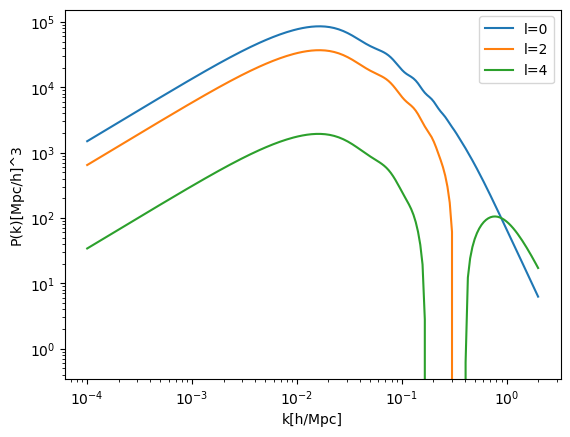

In [8]:
plt.loglog(kh, real_model[0], label='l=0')
plt.loglog(kh, real_model[2], label='l=2')
plt.loglog(kh, real_model[4], label='l=4')
plt.legend()
plt.xlabel('k[h/Mpc]')
plt.ylabel('P(k)[Mpc/h]^3')


check of the model

In [9]:

s, xi0 = hankl.P2xi(kh, real_model[0]*np.exp(-kh**2), l=0)

/home/elisalentini/miniconda3/envs/acc-env/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/elisalentini/miniconda3/envs/acc-env/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


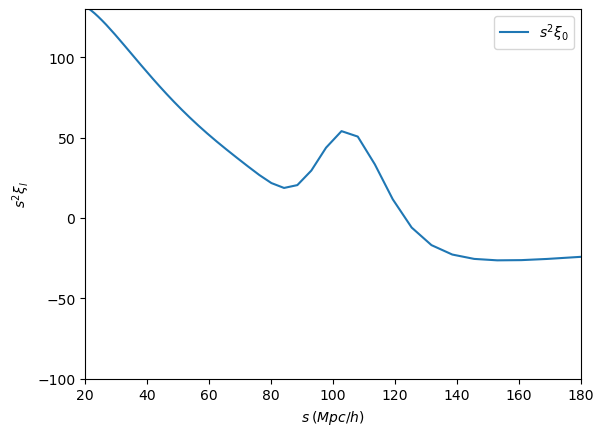

In [10]:
plt.plot(s, s*s*xi0, label=r'$s^{2}\xi_{0}$')
#plt.plot(s, s*s*xi2, label=r'$s^{2}\xi_{2}$')
plt.xlim(20,180)
plt.ylim(-100,130)
plt.xlabel(r'$s\: (Mpc/h)$')
plt.ylabel(r'$s^{2} \xi_{l}$')
plt.legend()
plt.show()

load data: xi of BOSS computed with the Euclid code

In [11]:
r = np.load('r.npy')
cov_z1 = np.load('cov_xi_z1.npy')
#cov_z3 = np.load('cov_xi_z3.npy')
xi0_low = np.load('xi0_tot_low.npy')
xi2_low = np.load('xi2_tot_low.npy')


Define the likelihood. from pk to xi using an hankle transformation

In [12]:
def log_likelihood(theta,data, inv_cov):
    b, f, sigma_v = theta
    p_k_mu = lambda k, mu: (b + f*mu**2)**2*PK_dw(k)*np.exp(-f**2*k**2*mu**2*sigma_v**2)
    p_k_l ={}
    for ll in l_list:
        leg = legendre(ll)(mu)
        p_k_l[ll] = 0.5 * (2*ll+1) * np.array([np.sum(weights * p_k_mu(k, mu) * leg)  for k in kh])
    #model_big = p_l(l_list, kh)
    s, xi0 = hankl.P2xi(kh, p_k_l[0]*np.exp(-kh**2), l=0)
    _, xi2 = hankl.P2xi(kh, p_k_l[2]*np.exp(-kh**2), l=2)
    model1 = scipy.interpolate.interp1d(s,xi0,kind='cubic')
    model2 = scipy.interpolate.interp1d(s,xi2, kind='cubic')
    model = np.concatenate([model1(r), model2(r)])
    residual = data - model
    return -0.5*np.dot(residual, np.dot(inv_cov, residual))

In [13]:
data = np.concatenate([xi0_low,xi2_low])
inv_cov_z1 = np.linalg.inv(cov_z1)


In [14]:
data.shape

(80,)

In [15]:
inv_cov_z1.shape

(80, 80)

In [16]:
#initialize the parameters
b1 = 2.0
f = 0.71
sigma_v = 3.0


I use Iminuit to minimize $\chi^2$

In [17]:
def chi2(b, f, sigma_v):
    return -2*log_likelihood([b, f, sigma_v], data, inv_cov_z1)

initial = [b1, f, sigma_v]

m = iminuit.Minuit(chi2, *initial)
m.migrad()

/home/elisalentini/miniconda3/envs/acc-env/lib/python3.9/site-packages/iminuit/minuit.py:791: ComplexWarning: Casting complex values to real discards the imaginary part
  fm = migrad(ncall, self._tolerance)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.855e+04                  │              Nfcn = 363              │
│ EDM = 0.000118 (Goal: 0.0002)    │           time = 33.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b       │   2.279   │   0.007   │            │            │         │         │       │
│ 1 │ f       │   0.09    │   0.04    │            │            │         │         │       │
│ 2 │ sigma_v │    19     │     9     │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬────────────────────────────┐
│         │        b        f  sigma_v │
├─────────┼────────────────────────────┤
│       b │ 5.38e-05 -0.29e-3 61.97e-3 │
│       f │ -0.29e-3  0.00169  -0.3615 │
│ sigma_v │ 61.97e-3  -0.3615     77.5 │
└─────────┴────────────────────────────┘

In [18]:
#chi2 
chi2_min = m.fval
ndof = len(data) - 5
reduced_chi2 = chi2_min / ndof

In [19]:
from IPython.display import display, Markdown

display(Markdown(r'$b_1^N$ = {:.5f} +- {:.5f}'.format(m.values[0], m.errors[0])))
display(Markdown(r'$f$ = {:.5f} +- {:.5f}'.format(m.values[1], m.errors[1])))
display(Markdown(r'$\sigma_v^N$ = {:.5f} +- {:.5f}'.format(m.values[2], m.errors[2])))
display(Markdown(r'$\chi^2$ = {:.5f}'.format(chi2_min)))
display(Markdown(r'$ndof$ = {}'.format(ndof)))
display(Markdown(r'reduced $\chi^2$ = {:.5f}'.format(reduced_chi2)))




$b_1^N$ = 2.27861 +- 0.00733

$f$ = 0.08836 +- 0.04106

$\sigma_v^N$ = 19.39783 +- 8.80467

$\chi^2$ = 58546.65607

$ndof$ = 75

reduced $\chi^2$ = 780.62208

something goes wrong. The $\chi^2$ is too high

In [20]:
b1_fit = m.values[0]
f_fit = m.values[1]
sigma_v_fit = m.values[2]

In [30]:
p_k_mu_fit = lambda k, mu: (b1_fit + f_fit*mu**2)**2*PK_dw(k)*np.exp(-f_fit*k**2*mu**2*sigma_v_fit**2)
#p_k_mu_fit_S = lambda k, mu: (b1_fit_S + f_fit*mu**2)**2*PK_dw(k)*np.exp(-f_fit*k**2*mu**2*sigma_v_fit_S**2)
p_k_l_fit ={}
#p_k_l_fit_S ={}
for ll in l_list:
    leg = legendre(ll)(mu)
    p_k_l_fit[ll] = 0.5 * (2*ll+1) * np.array([np.sum(weights * p_k_mu_fit(k, mu) * leg)  for k in kh])
    #p_k_l_fit_S[ll] = 0.5 * (2*ll+1) * np.array([np.sum(weights * p_k_mu_fit_S(k, mu) * leg)  for k in kh])

s, xi0_fit = hankl.P2xi(kh, p_k_l_fit[0]*np.exp(-kh**2), l=0)
_, xi2_fit = hankl.P2xi(kh, p_k_l_fit[2]*np.exp(-kh**2), l=2)
interp_pk_1 = scipy.interpolate.interp1d(kh, p_k_l_fit[0], kind='cubic', fill_value='extrapolate')
interp_pk_2 = scipy.interpolate.interp1d(kh, p_k_l_fit[2], kind='cubic', fill_value='extrapolate')

In [24]:
print(r.shape)
print(xi0_fit.shape)

(40,)
(200,)


In [25]:
interp_xi0_fit = scipy.interpolate.interp1d(s, xi0_fit, kind='cubic', fill_value='extrapolate')
interp_xi2_fit = scipy.interpolate.interp1d(s, xi2_fit, kind='cubic', fill_value='extrapolate')


In [ ]:
s, xi0_fit2 = hankl.P2xi(kh, interp_pk_1*np.exp(-kh**2), l=0)

In [32]:
s, xi0_fit3 = hankl.P2xi(kh, p_k_l_fit[0]*np.exp(-kh**2), l=0)

/home/elisalentini/miniconda3/envs/acc-env/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/elisalentini/miniconda3/envs/acc-env/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


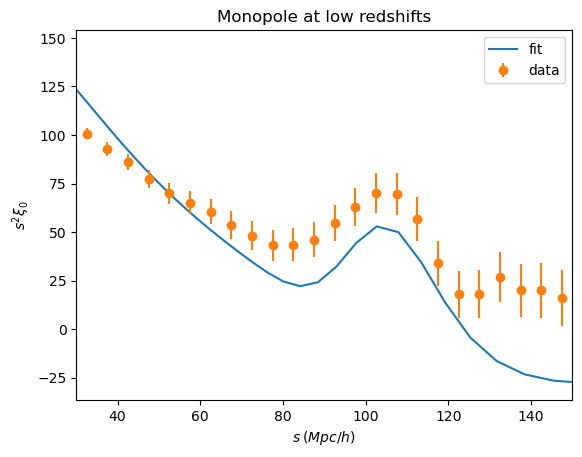

In [34]:
plt.plot(s, s*s*xi0_fit3, label='fit')
plt.errorbar(r,r**2*xi0_low, yerr=r**2*std[:len(r)],fmt='o',label='data')
plt.xlim(30,150)
#plt.ylim(-100,130)
plt.xlabel(r'$s\: (Mpc/h)$')
plt.ylabel(r'$s^{2} \xi_{0}$')
plt.title('Monopole at low redshifts')
plt.legend()
plt.show()

In [26]:
std=np.sqrt(np.diagonal(cov_z1))

In [27]:
std.shape

(80,)

In [28]:
plt.plot(s, s*s*interp_xi0_fit, label='fit')
plt.errorbar(r,r**2*xi0_low, yerr=r**2*std[:len(r)],fmt='o',label='data')
plt.xlim(30,150)
#plt.ylim(-100,130)
plt.xlabel(r'$s\: (Mpc/h)$')
plt.ylabel(r'$s^{2} \xi_{0}$')
plt.title('Monopole at low redshifts')
plt.legend()
plt.show()

TypeError: unsupported operand type(s) for *: 'float' and 'interp1d'

Plot the best fit model with the data

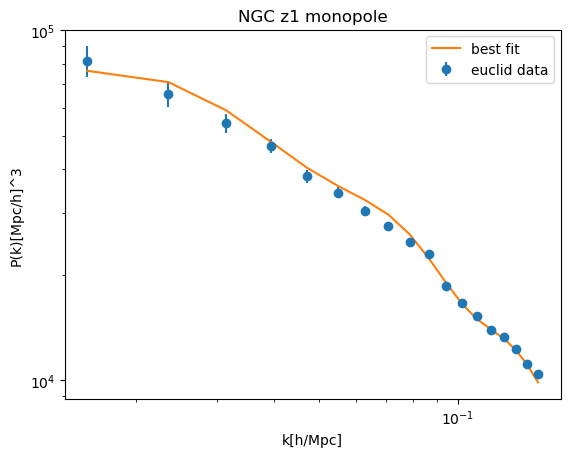

In [ ]:
plt.errorbar(k_eff, ngc_z1_monopole, yerr=np.sqrt(np.diag(cov_ngc_z1))[:len(k_eff)], fmt='o', label='euclid data')
plt.plot(k_eff, interp_pk_N_1(k_eff), label='best fit')
plt.xlabel('k[h/Mpc]')
plt.ylabel('P(k)[Mpc/h]^3')
plt.title('NGC z1 monopole')    
plt.xscale('log')
plt.yscale('log')
plt.legend()


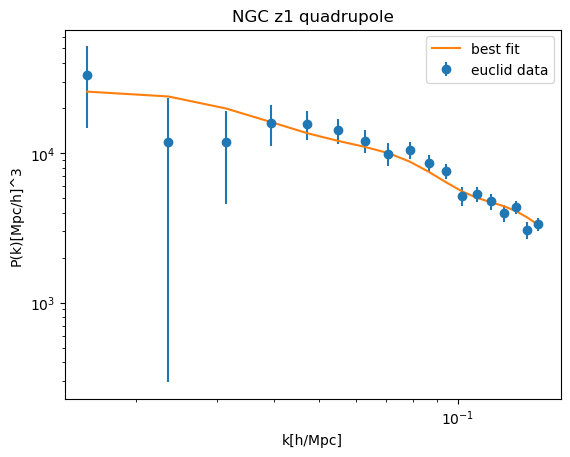

In [ ]:
plt.errorbar(k_eff, ngc_z1_quadrupole, yerr=np.sqrt(np.diag(cov_ngc_z1))[len(k_eff):2*len(k_eff)], fmt='o', label='euclid data')
plt.plot(k_eff, interp_pk_N_2(k_eff), label='best fit')
plt.xlabel('k[h/Mpc]')
plt.ylabel('P(k)[Mpc/h]^3')
plt.title('NGC z1 quadrupole')
plt.xscale('log')
plt.yscale('log')
plt.legend()    

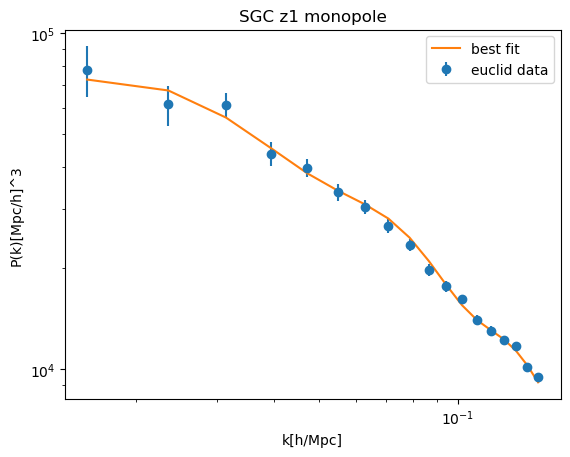

In [ ]:
plt.errorbar(k_eff, sgc_z1_monopole, yerr=np.sqrt(np.diag(cov_sgc_z1))[:len(k_eff)], fmt='o', label='euclid data')
plt.plot(k_eff, interp_pk_S_1(k_eff), label='best fit')
plt.xlabel('k[h/Mpc]')
plt.ylabel('P(k)[Mpc/h]^3')
plt.title('SGC z1 monopole')
plt.xscale('log')
plt.yscale('log')
plt.legend()

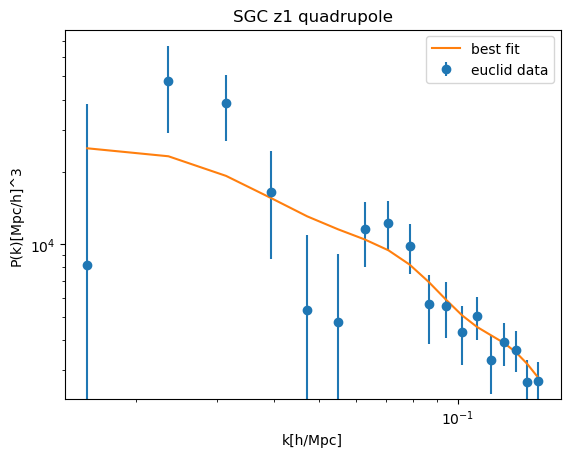

In [ ]:
plt.errorbar(k_eff, sgc_z1_quadrupole, yerr=np.sqrt(np.diag(cov_sgc_z1))[len(k_eff):2*len(k_eff)], fmt='o', label='euclid data')
plt.plot(k_eff, interp_pk_S_2(k_eff), label='best fit')
plt.xlabel('k[h/Mpc]')
plt.ylabel('P(k)[Mpc/h]^3')
plt.title('SGC z1 quadrupole')
plt.xscale('log')
plt.yscale('log')
plt.legend()